In [1]:
import numpy as np

import unicodedata
import re
import json
import random

import nltk
from nltk.stem.porter import PorterStemmer	
stemmer = PorterStemmer()

from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

import warnings 
warnings.filterwarnings('ignore')


In [2]:
from DZ1_data import GetData

In [3]:
# from huggingface_hub import login
# login()

In [4]:
elrian_dialogues, leonard_dialogues = GetData()

In [5]:
# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large", padding_side='left')
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-large")

In [6]:
# Установка токена паддинга
tokenizer.pad_token = tokenizer.eos_token

# Токенизация данных с явным указанием параметра padding
tokenized_data = tokenizer(elrian_dialogues, return_tensors="pt", truncation=True, padding=True)

In [7]:
# Определение класса MyDataset, который наследуется от torch.utils.data.Dataset
class MyDataset(Dataset):
    # Конструктор класса
    def __init__(self, elrian_dialogues, leonard_dialogues, tokenizer):
        # Сохранение переданных данных в атрибуты класса
        self.elrian_dialogues = elrian_dialogues
        self.leonard_dialogues = leonard_dialogues
        self.tokenizer = tokenizer

    # Метод, возвращающий длину датасета
    def __len__(self):
        return len(self.elrian_dialogues)

    # Метод, возвращающий элемент датасета по указанному индексу
    def __getitem__(self, idx):
        # Получение elrian_input и leonard_target для текущего индекса
        elrian_input = self.elrian_dialogues[idx]
        leonard_target = self.leonard_dialogues[idx]

        # Токенизация elrian_input с добавлением токенов паддинга и обрезкой
        tokenized_data = self.tokenizer(elrian_input, return_tensors="pt", padding=True, truncation=True)

        # Создание меток (labels) путем сдвига входной последовательности
        labels = self.tokenizer(leonard_target, return_tensors="pt", padding=True, truncation=True)["input_ids"]

         # Возвращение словаря с ключами "input_ids" и "labels", сжатых до размерности 1
        return {
            "input_ids": tokenized_data["input_ids"].squeeze(),
            "labels": labels.squeeze()
        }

# Создание экземпляра датасета и DataLoader
my_dataset = MyDataset(elrian_dialogues, leonard_dialogues, tokenizer)
train_data_loader = DataLoader(my_dataset, batch_size=1, shuffle=True, collate_fn=lambda batch: batch)


In [8]:
# Подготовка модели для дообучения
# тут добавляю новый слой который планирую дообучать
# в связи с малым датасетом, обуение до слоя шло очень плохо.
# код оставлю, что бы показать, то как это делал
# new_layer = torch.nn.Linear(model.config.hidden_size, len(tokenizer.get_vocab()))
# model.lm_head = new_layer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# !!!! Тут хардкожу CPU, т.к. у меня не хватате памяти для обучения на видеокарте
device = 'cpu'
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [10]:
# Определение оптимизатора и функции потерь
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [18]:
# всего обучал на большем количестве эпох, перезапуская после каждой итерации
num_epochs = 3

In [12]:
losses = []

In [13]:
# Тут загружаю историю loss для формирования графика
# Использую в случаях, если обучение разбито на несколько сессий
# with open('./DZ1model/DialogGPT/losses.pkl', 'rb') as file:
#     losses = pickle.load(file)

In [35]:
# Цикл по эпохам обучения
for epoch in range(num_epochs):
    # Перевод модели в режим обучения
    model.train()
    # Обнуление суммарной потери на текущей эпохе
    total_loss = 0

    # Итерация по батчам в DataLoader с отображением прогресса
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch + 1}"):

        # Извлечение входных данных (input_ids) и меток (labels) из текущего батча
        inputs = batch[0]["input_ids"].to(device)
        labels = batch[0]["labels"].to(device)

        # Выравнивание длины последовательностей до минимальной длины в текущем батче
        min_length = min(inputs.size(0), labels.size(0))
        inputs = inputs[:min_length]
        labels = labels[:min_length]

        # Обнуление градиентов перед обратным распространением
        optimizer.zero_grad()

        # Получение выходов модели и вычисление потери
        outputs = model(inputs, labels=labels.flatten())
        loss = outputs.loss
        total_loss += loss.item()

        losses.append(loss.detach().numpy())

        # Обратное распространение градиентов
        loss.backward()

        # Обновление весов модели с использованием оптимизатора
        optimizer.step()

    # Вычисление средней потери на текущей эпохе и вывод информации
    average_loss = total_loss / len(train_data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")


Epoch 1: 100%|██████████| 98/98 [06:02<00:00,  3.70s/it]


Epoch 1, Average Loss: 0.5170824900269508


Epoch 2:  50%|█████     | 49/98 [02:54<02:54,  3.57s/it]


KeyboardInterrupt: 

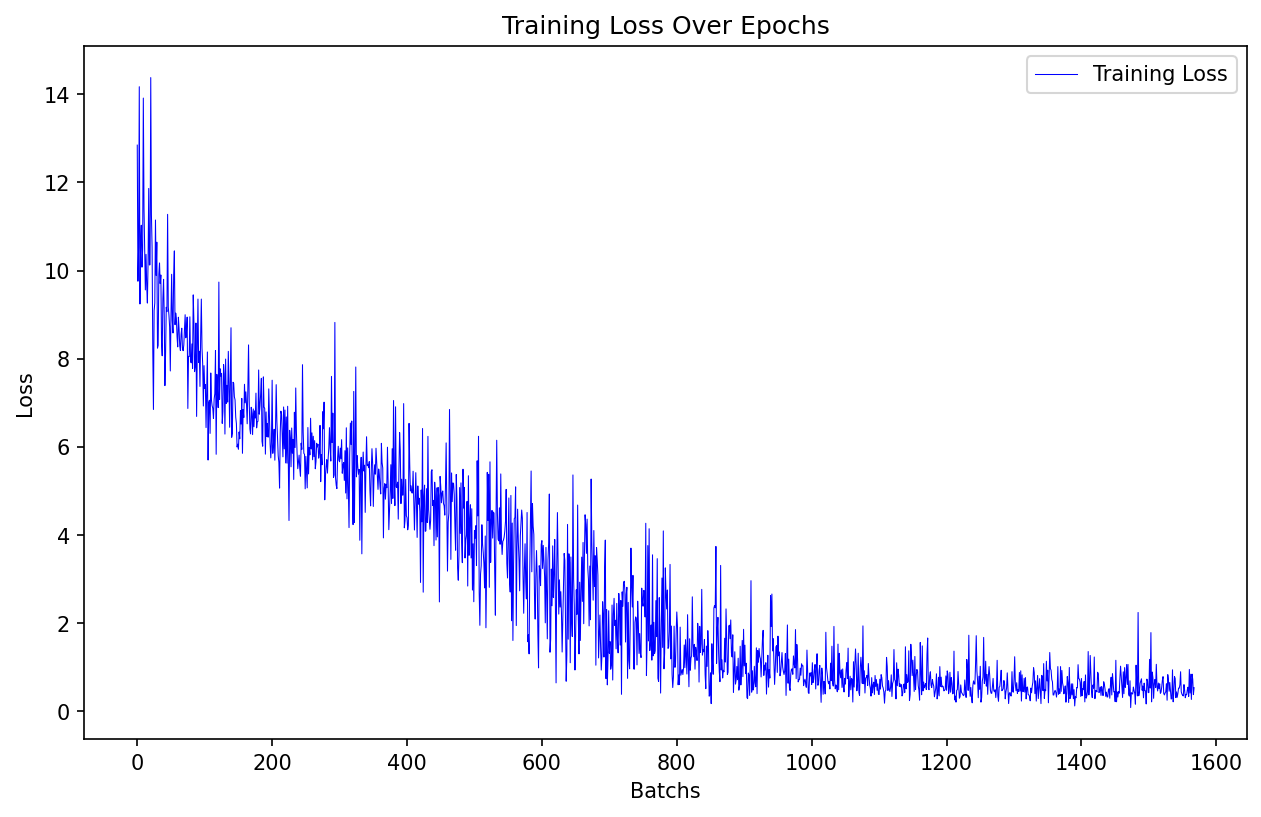

In [32]:
plt.figure(figsize=(10, 6), dpi=150)

plt.plot(range(0, len(losses)), losses, linestyle='-', color='b', linewidth=0.5, marker='', label='Training Loss')

plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.show()

In [36]:
with open('./DZ1model/DialogGPT_2/losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

In [37]:
model.save_pretrained("./DZ1model/DialogGPT_2")
tokenizer.save_pretrained("./DZ1model/DialogGPT_2")

('./DZ1model/DialogGPT_2/tokenizer_config.json',
 './DZ1model/DialogGPT_2/special_tokens_map.json',
 './DZ1model/DialogGPT_2/vocab.json',
 './DZ1model/DialogGPT_2/merges.txt',
 './DZ1model/DialogGPT_2/added_tokens.json',
 './DZ1model/DialogGPT_2/tokenizer.json')